## Intro
**Zillow**<br>
: an online real estate database company founded in 2006<br><br>
**Zestimate**<br>
: estimate home value based on 7.5 million statical and mahin laerning models that analyze hundreds of data point on each property<br>
: contiually imporving the median margin of error<br><br>
**Objective**<br>
: building a model to improving Zestimate error


## import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from plotnine import *


## load data

In [2]:
train_df=pd.read_csv("/content/train_2016_v2.csv", parse_dates=["transactiondate"])
print("shape : ",train_df.shape)
train_df.head()

shape :  (90275, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [3]:
property_df=pd.read_csv("/content/properties_2016.csv")
print("shape : ",property_df.shape)
property_df.head()

shape :  (312797, 58)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


## Train dataset

In [4]:
train_df.columns

Index(['parcelid', 'logerror', 'transactiondate'], dtype='object')

### Logerror<br>
target variable for this competition


outlier exist in both ends

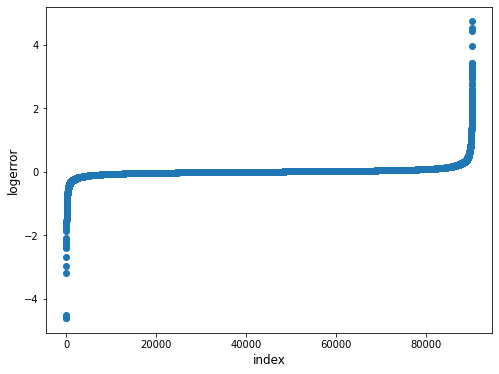

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df.logerror.values))
plt.xlabel("index",fontsize=12)
plt.ylabel("logerror",fontsize=12)
plt.show()

remove outlier & plot histogram<br>
-> normal distribution on log error 

In [6]:
ulimit=np.percentile(train_df.logerror.values,99)
llimit=np.percentile(train_df.logerror.values,1)
train_df["logerror"].loc[train_df["logerror"]>ulimit]=ulimit
train_df["logerror"].loc[train_df["logerror"]<llimit]=llimit

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


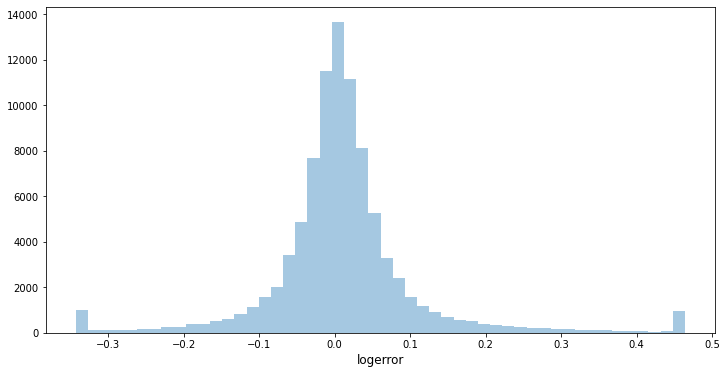

In [7]:
plt.figure(figsize=(12,6))
sns.distplot(train_df.logerror.values,bins=50,kde=False)
plt.xlabel("logerror",fontsize=12)
plt.show()


### Transaction Date<br>
check # of transaction in each month

contain all transactions before October 15,2016

In [8]:
train_df["transaction_month"]=train_df["transactiondate"].dt.month
cnt_srs=train_df["transaction_month"].value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


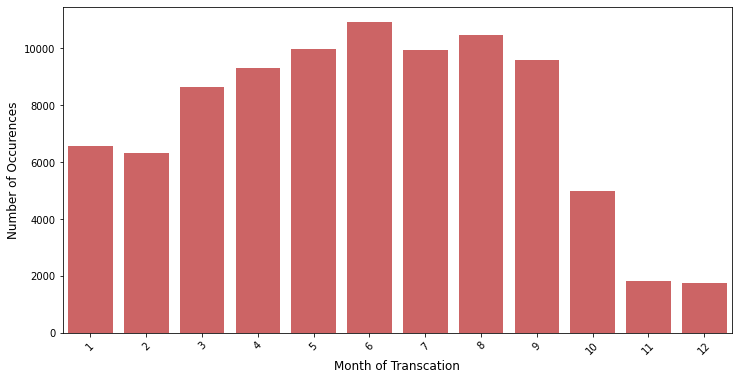

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values,alpha=0.8, color=color[3])
plt.xticks(rotation=45)
plt.xlabel("Month of Transcation", fontsize=12)
plt.ylabel("Number of Occurences",fontsize=12)
plt.show()

### Pracel Id

In [10]:
(train_df["parcelid"].value_counts().reset_index())["parcelid"].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

## Properties 2016<br>


In [11]:
property_df.shape

(312797, 58)

In [12]:
property_df.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

check NaN values in dataset

In [13]:
missing_df=property_df.isnull().sum(axis=0).reset_index()
missing_df.columns=["column_name","missing_count"]
missing_df=missing_df[missing_df["missing_count"]>0]
missing_df=missing_df.sort_values(by="missing_count")

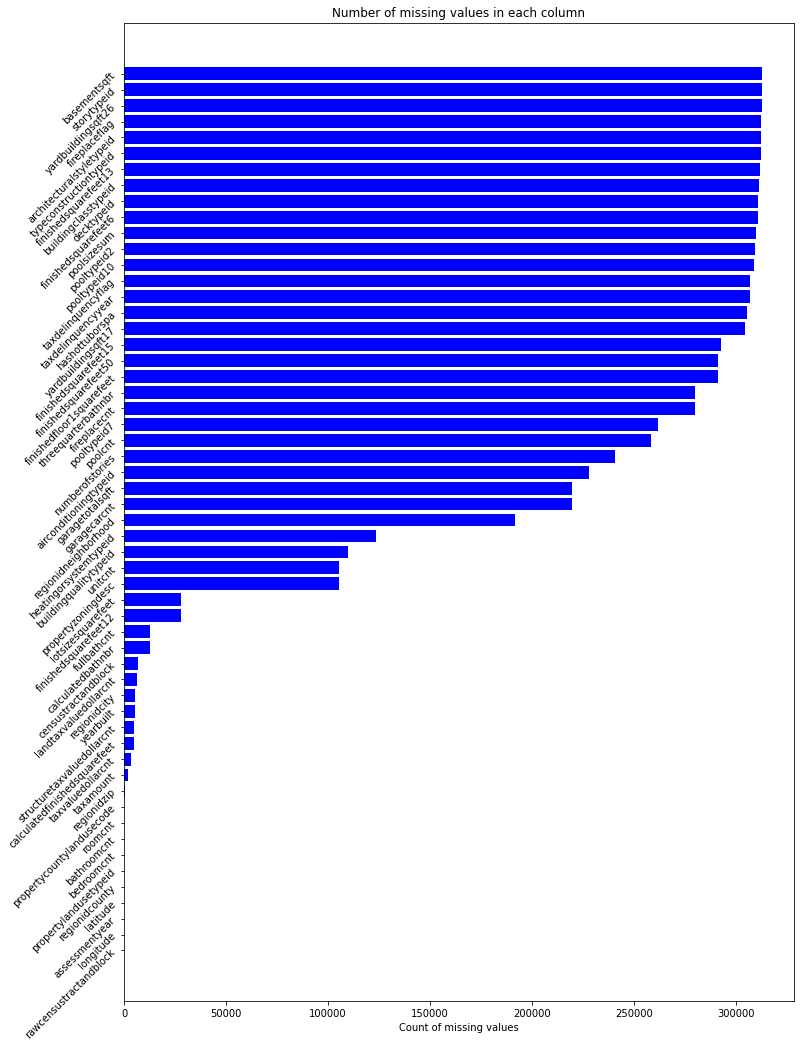

In [14]:
ind=np.arange(missing_df.shape[0])
width=0.9
fig,ax=plt.subplots(figsize=(12,18))
rects=ax.barh(ind,missing_df.missing_count.values, color="blue")
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values,rotation=45)
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


### longitude & latitude

* provide with full list of real estate properties in **Log Angeles, Orange and Ventura, California** 
* train data : 90811 rows
* property data :  2,985,217 <br>
=> merge two data and do analysis

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

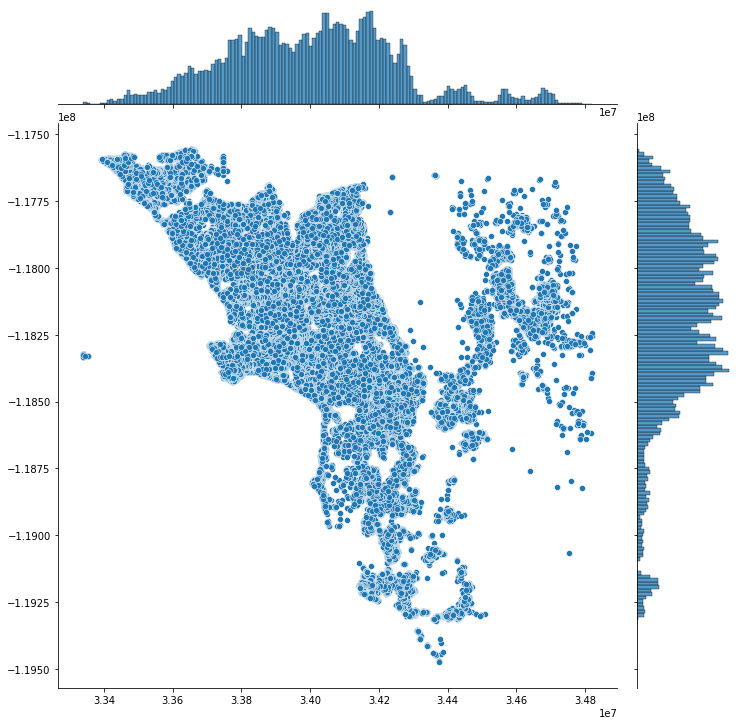

In [15]:
plt.figure(figsize=(12,12))
sns.jointplot(x=property_df.latitude.values,y=property_df.longitude.values,size=10)
plt.xlabel("Logitude",fontsize=12)
plt.ylabel("Latitude",fontsize=12)
plt.show()

merge dataset and property set

In [16]:
train_df=pd.merge(train_df,property_df, on="parcelid",how="left")
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12643413,0.0218,2016-01-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### check data type

* most of float variables and few categorical variables

In [17]:
pd.options.display.max_rows=65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns=["Count","Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


In [18]:
dtype_df.groupby("Column Type").aggregate("count").reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


check # of Null in new merged dataset

In [19]:
missing_df=train_df.isnull().sum(axis=0).reset_index()
missing_df.columns=["column_name","missing_count"]
missing_df["missing_ratio"]=missing_df["missing_count"]/train_df.shape[0]
missing_df[missing_df["missing_ratio"]>0.999]

,column_name,missing_count,missing_ratio
5,architecturalstyletypeid,90251,0.999734
6,basementsqft,90270,0.999945
9,buildingclasstypeid,90274,0.999989
12,decktypeid,90202,0.999191
16,finishedsquarefeet13,90272,0.999967
19,finishedsquarefeet6,90245,0.999668
44,storytypeid,90270,0.999945
46,typeconstructiontypeid,90245,0.999668
49,yardbuildingsqft26,90267,0.999911
52,fireplaceflag,90251,0.999734


## Univariate Analysis : 단변량 분석
feature와 target 사이에 주용한 통계적 관계 계산하고 관련성 판단해 feature 선택 

In [20]:
## impute missing value with mean value to compute correlation coefficient
mean_values=train_df.mean(axis=0)

train_df_new=train_df.fillna(mean_values)
train_df.fillna(mean_values,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [21]:
print(train_df_new.shape)
train_df_new.head()

(90275, 61)


,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.802375,7.625,1000.2,2.268261,3.031394,4.0,5.59028,2.295161,66.0,1357.775815,1767.607459,1743.462786,1400.0,2400.928571,1360.455163,2053.566667,6048.926957,1.202471,2.224481,1.809925,341.518102,1,3.914171,3.400425e+07,-1.181970e+08,29045.005319,1.0,532.514851,1.0,1.0,1.0,NaN,261.891063,NaN,6.049236e+07,33042.52147,2524.621808,197054.371972,96573.222234,1.467978,7.0,1.006029,5.933333,1.113507,301.85274,333.25,1968.656191,1.453278,1,179905.34376,456200.060799,2015.0,276840.683445,5975.149668,NaN,13.308901,6.049224e+13
1,14366692,-0.1684,2016-01-01,1,1.802375,7.625,1000.2,2.268261,3.031394,4.0,5.59028,2.295161,66.0,1357.775815,1767.607459,1743.462786,1400.0,2400.928571,1360.455163,2053.566667,6048.926957,1.202471,2.224481,1.809925,341.518102,1,3.914171,3.400425e+07,-1.181970e+08,29045.005319,1.0,532.514851,1.0,1.0,1.0,NaN,261.891063,NaN,6.049236e+07,33042.52147,2524.621808,197054.371972,96573.222234,1.467978,7.0,1.006029,5.933333,1.113507,301.85274,333.25,1968.656191,1.453278,1,179905.34376,456200.060799,2015.0,276840.683445,5975.149668,NaN,13.308901,6.049224e+13
2,12098116,-0.0040,2016-01-01,1,1.802375,7.625,1000.2,2.268261,3.031394,4.0,5.59028,2.295161,66.0,1357.775815,1767.607459,1743.462786,1400.0,2400.928571,1360.455163,2053.566667,6048.926957,1.202471,2.224481,1.809925,341.518102,1,3.914171,3.400425e+07,-1.181970e+08,29045.005319,1.0,532.514851,1.0,1.0,1.0,NaN,261.891063,NaN,6.049236e+07,33042.52147,2524.621808,197054.371972,96573.222234,1.467978,7.0,1.006029,5.933333,1.113507,301.85274,333.25,1968.656191,1.453278,1,179905.34376,456200.060799,2015.0,276840.683445,5975.149668,NaN,13.308901,6.049224e+13
3,12643413,0.0218,2016-01-02,1,1.802375,7.625,1000.2,2.268261,3.031394,4.0,5.59028,2.295161,66.0,1357.775815,1767.607459,1743.462786,1400.0,2400.928571,1360.455163,2053.566667,6048.926957,1.202471,2.224481,1.809925,341.518102,1,3.914171,3.400425e+07,-1.181970e+08,29045.005319,1.0,532.514851,1.0,1.0,1.0,NaN,261.891063,NaN,6.049236e+07,33042.52147,2524.621808,197054.371972,96573.222234,1.467978,7.0,1.006029,5.933333,1.113507,301.85274,333.25,1968.656191,1.453278,1,179905.34376,456200.060799,2015.0,276840.683445,5975.149668,NaN,13.308901,6.049224e+13
4,14432541,-0.0050,2016-01-02,1,1.802375,7.625,1000.2,2.268261,3.031394,4.0,5.59028,2.295161,66.0,1357.775815,1767.607459,1743.462786,1400.0,2400.928571,1360.455163,2053.566667,6048.926957,1.202471,2.224481,1.809925,341.518102,1,3.914171,3.400425e+07,-1.181970e+08,29045.005319,1.0,532.514851,1.0,1.0,1.0,NaN,261.891063,NaN,6.049236e+07,33042.52147,2524.621808,197054.371972,96573.222234,1.467978,7.0,1.006029,5.933333,1.113507,301.85274,333.25,1968.656191,1.453278,1,179905.34376,456200.060799,2015.0,276840.683445,5975.149668,NaN,13.308901,6.049224e+13


In [22]:
# correlation coefficient of each variable
x_cols=[col for col in train_df_new.columns if col not in ["logerror"] if train_df_new[col].dtype=="float64"]

* correlation of target variable with given variable are low
* variable at top do not have any correlation value, need to be checked

In [23]:
labels=[]
values=[]

for col in x_cols:
  labels.append(col)
  values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror,values)[0,1])
  corr_df=pd.DataFrame({"col_labels": labels, "corr_values":values})
  corr_df=corr_df.sort_values(by="corr_values")


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


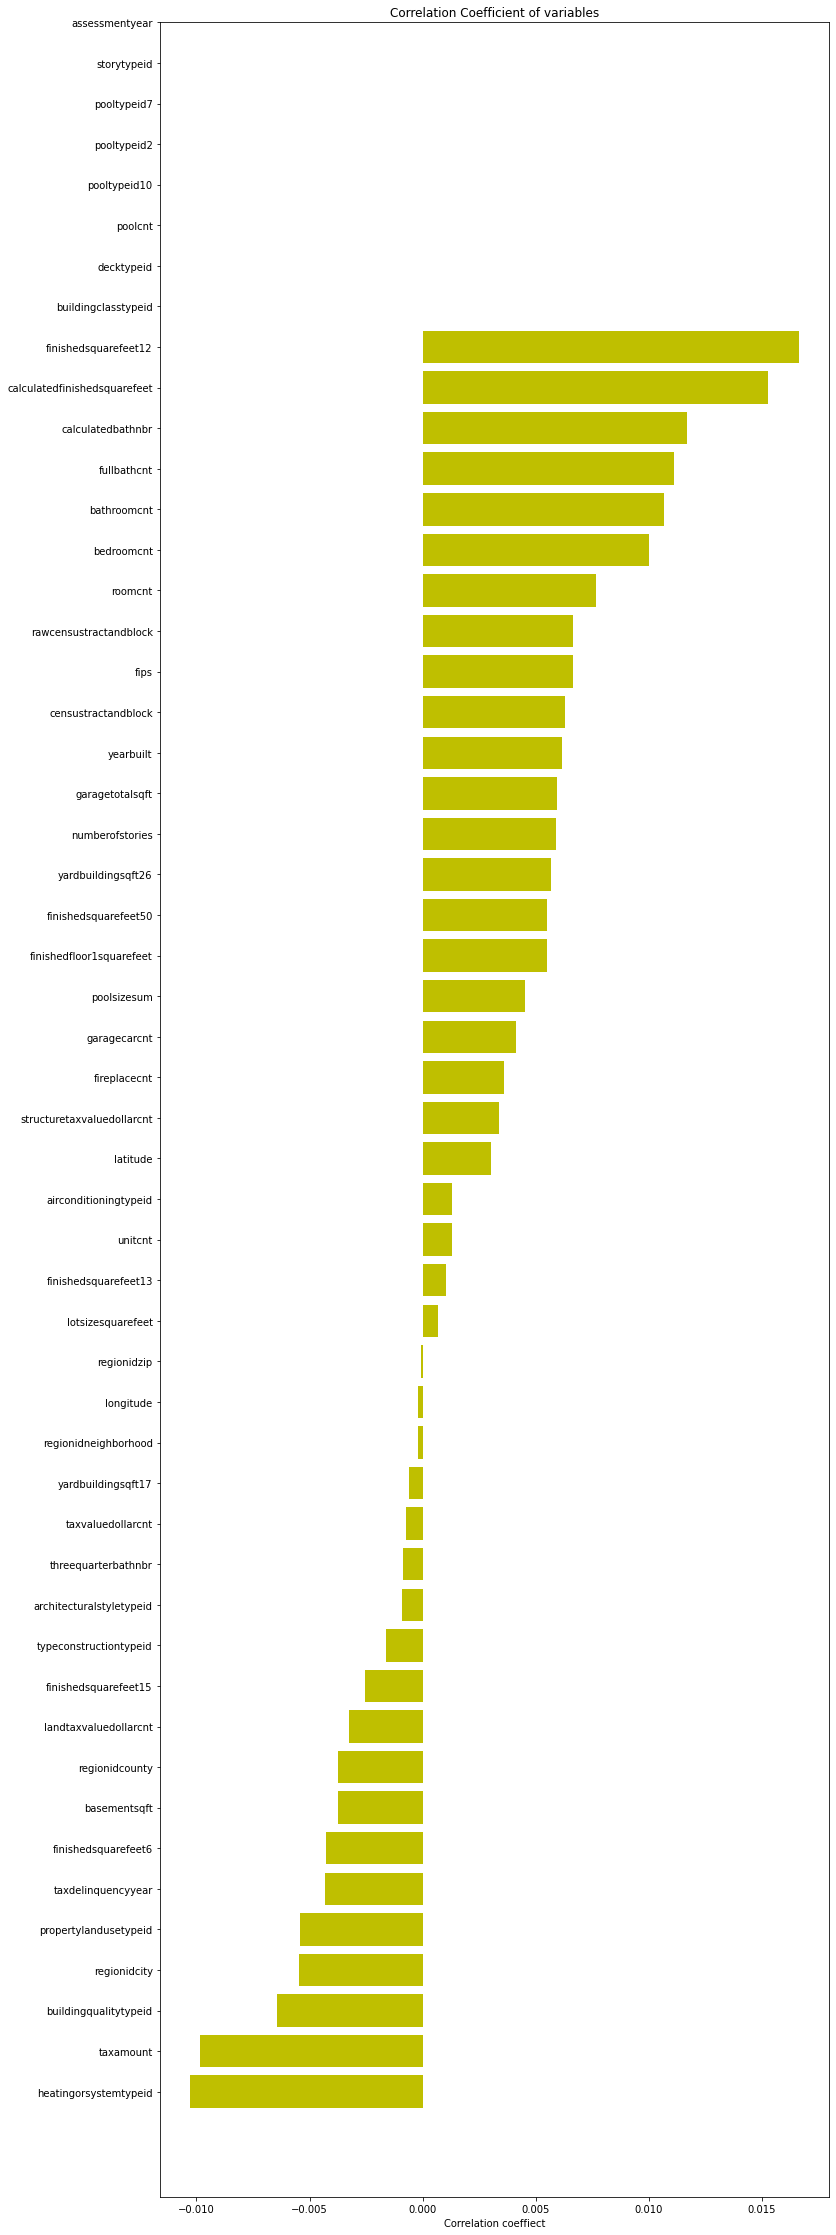

In [24]:
ind=np.arange(len(labels))
width=0.9
fig,ax=plt.subplots(figsize=(12,40))
rects=ax.barh(ind,np.array(corr_df.corr_values.values),color="y")
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation="horizontal")
ax.set_xlabel("Correlation coeffiect")
ax.set_title("Correlation Coefficient of variables")
plt.show()

In [25]:
corr_zerp_cols=['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']

In [26]:
for col in corr_zerp_cols:
  print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


In [27]:
corr_df_sel=corr_df[ (corr_df["corr_values"]>0.02) | (corr_df["corr_values"]<-0.01)]
corr_df_sel

,col_labels,corr_values
21,heatingorsystemtypeid,-0.01028


highly correlated
* Finished SquareFeet 12
* Calculated Finished square feet
* bathroom count
* bedroom count
* yearbuilt


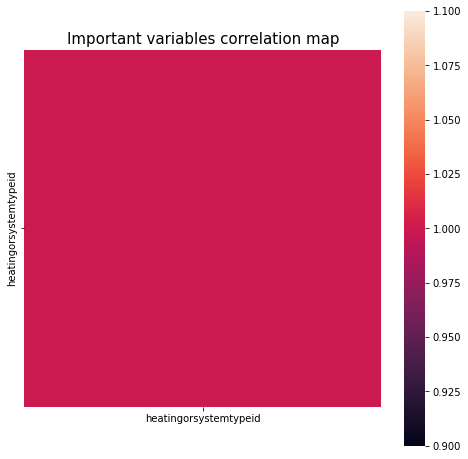

In [28]:
cols_to_use=corr_df_sel.col_labels.tolist()

temp_df=train_df[cols_to_use]
corrmat=temp_df.corr(method="spearman")
f,ax=plt.subplots(figsize=(8,8))

# heapmap with seaborn
sns.heatmap(corrmat,vmax=1.,square=True)
plt.title("Important variables correlation map",fontsize=15)
plt.show()

## Finished SquareFeet 12
`highly correlated`
* range of logerror narrows down with increase in finished square feet 12<br>



In [29]:
# how finishedsquarefeet12 varies with log error

col="finishedsquarefeet12"
ulimit=np.percentile(train_df[col].values,99.5)
llimit=np.percentile(train_df[col].values,0.5)
train_df[col].loc[train_df[col]>ulimit]=ulimit
train_df[col].loc[train_df[col]<llimit]=llimit

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

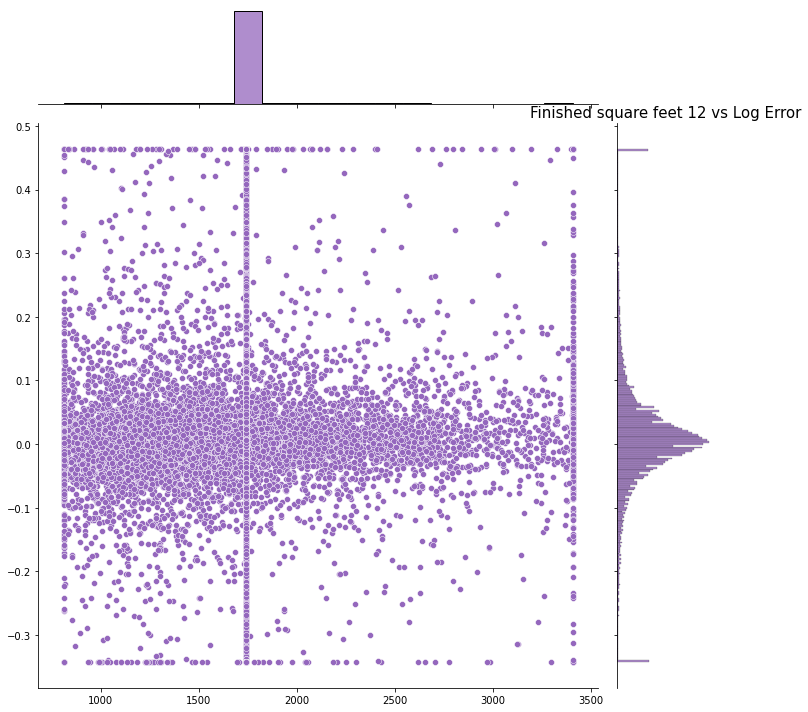

In [30]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values,size=10,color=color[4])
plt.ylabel("Log Error", fontsize=12)
plt.xlabel("Finished Square Feet 12",fontsize=12)
plt.title("Finished square feet 12 vs Log Error",fontsize=15)
plt.show()

## Calculated finished squareFeet

`highly correlated`
* range of logerror narrows down with increase in Calculated finished square feet

In [31]:
# how calculatedfinishedsquarefeet varies with log error

col="calculatedfinishedsquarefeet"
ulimit=np.percentile(train_df[col].values,99.5)
llimit=np.percentile(train_df[col].values,0.5)
train_df[col].loc[train_df[col]>ulimit]=ulimit
train_df[col].loc[train_df[col]<llimit]=llimit

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

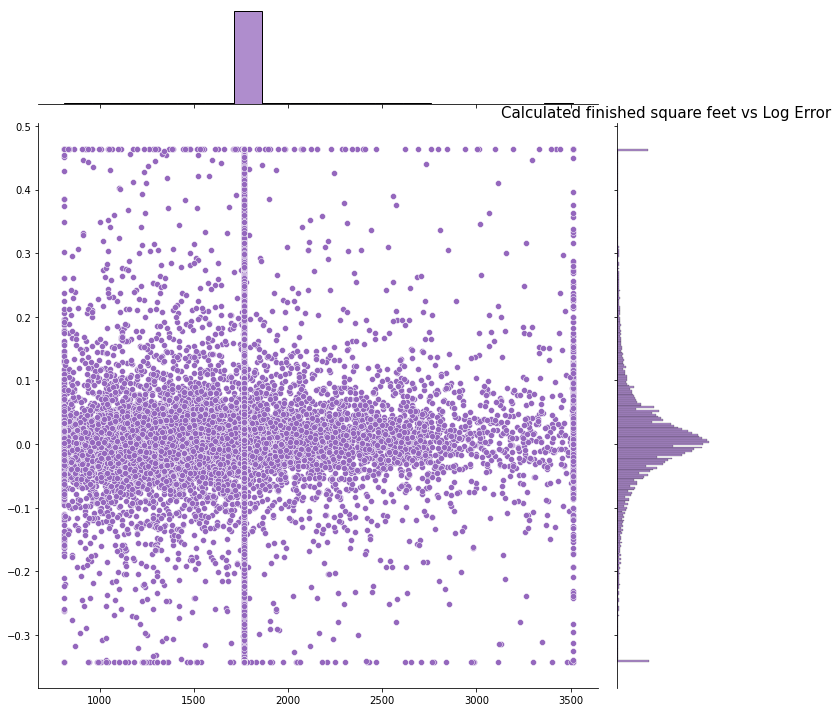

In [32]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values,size=10,color=color[4])
plt.ylabel("Log Error", fontsize=12)
plt.xlabel("Calculated finished square feet",fontsize=12)
plt.title("Calculated finished square feet vs Log Error",fontsize=15)
plt.show()

## Bathroom count 

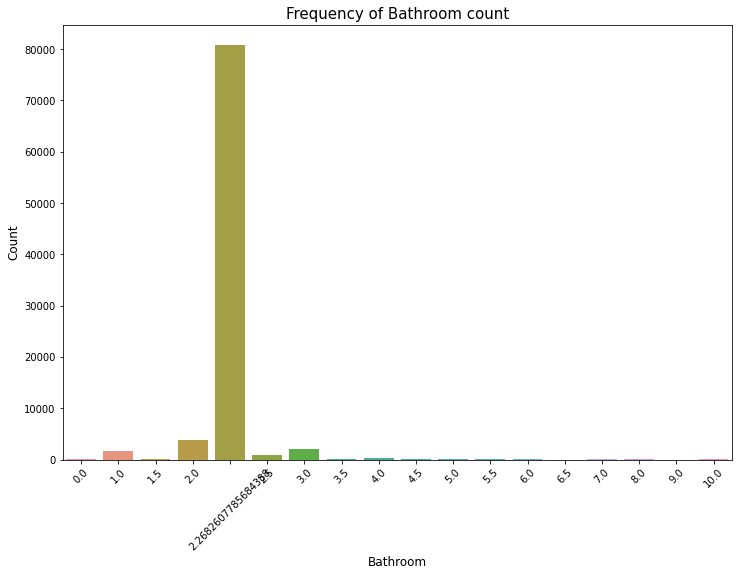

In [33]:
#check distribuiton of bathroomcount continous value
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt",data=train_df)
plt.ylabel("Count",fontsize=12)
plt.xlabel("Bathroom",fontsize=12)
plt.xticks(rotation=45)
plt.title("Frequency of Bathroom count",fontsize=15)
plt.show()

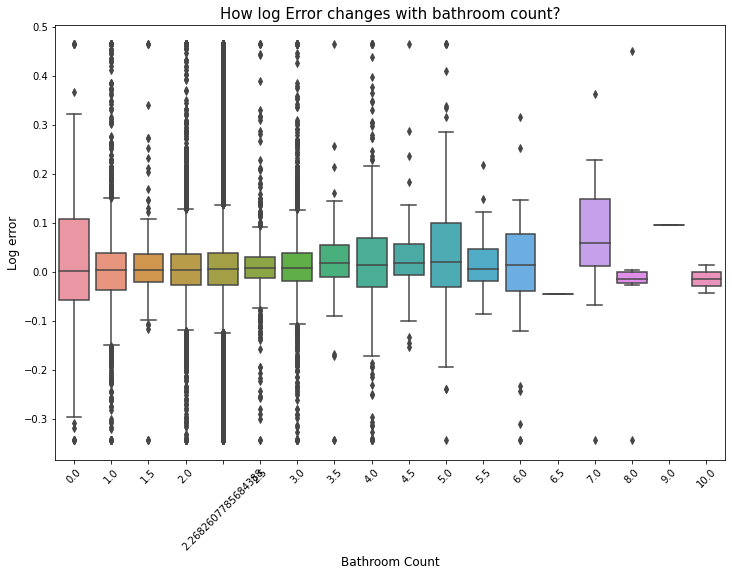

In [34]:
# check change of log error 
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt",y="logerror",data=train_df)
plt.ylabel("Log error",fontsize=12)
plt.xlabel("Bathroom Count",fontsize=12)
plt.xticks(rotation=45)
plt.title("How log Error changes with bathroom count?",fontsize=15)
plt.show()


## Bedroom count

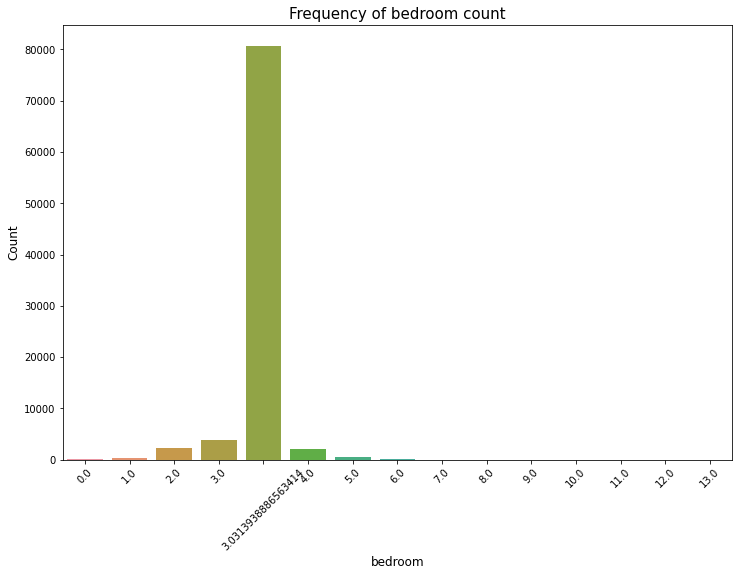

In [35]:
#check distribuiton of bedroomcount continous value
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt",data=train_df)
plt.ylabel("Count",fontsize=12)
plt.xlabel("bedroom",fontsize=12)
plt.xticks(rotation=45)
plt.title("Frequency of bedroom count",fontsize=15)
plt.show()

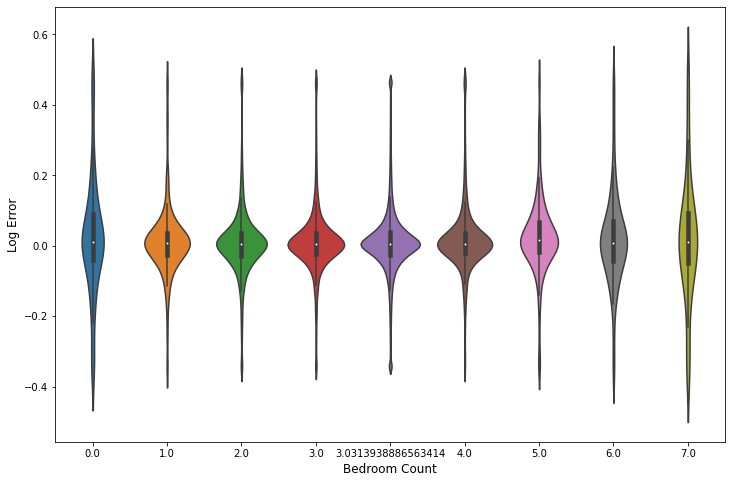

In [36]:
train_df["bedroomcnt"].loc[train_df["bedroomcnt"]>7]=7
plt.figure(figsize=(12,8))
sns.violinplot(x="bedroomcnt",y="logerror",data=train_df)
plt.xlabel("Bedroom Count",fontsize=12)
plt.ylabel("Log Error",fontsize=12)
plt.show()


## Tax amount

In [37]:
col="taxamount"
ulimit=np.percentile(train_df[col].values,99.5)
llimit=np.percentile(train_df[col].values,0.5)
train_df[col].loc[train_df[col]>ulimit]=ulimit
train_df[col].loc[train_df[col]<llimit]=llimit

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

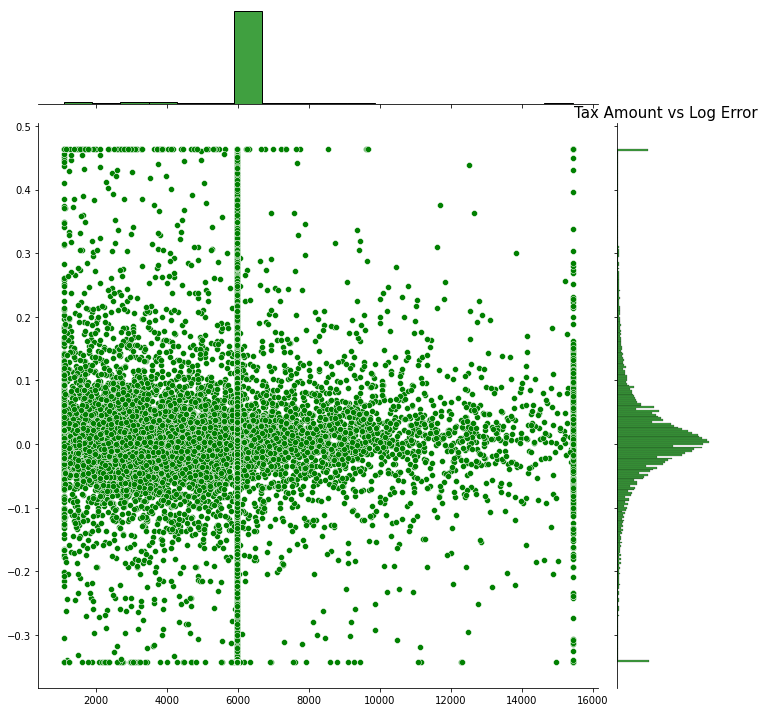

In [38]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df[col].values,y=train_df["logerror"].values,size=10,color="g")
plt.ylabel("Log Error",fontsize=12)
plt.xlabel("Tax Amount",fontsize=12)
plt.title("Tax Amount vs Log Error",fontsize=15)
plt.show()


## YearBuilt
* minot incremental trend with respect to built yeat

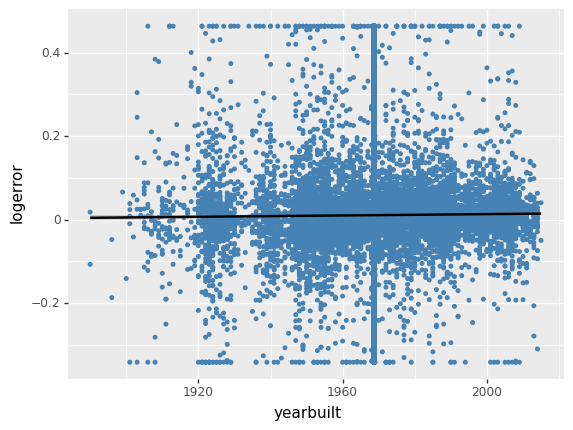

<ggplot: (8786890607249)>

In [39]:
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()

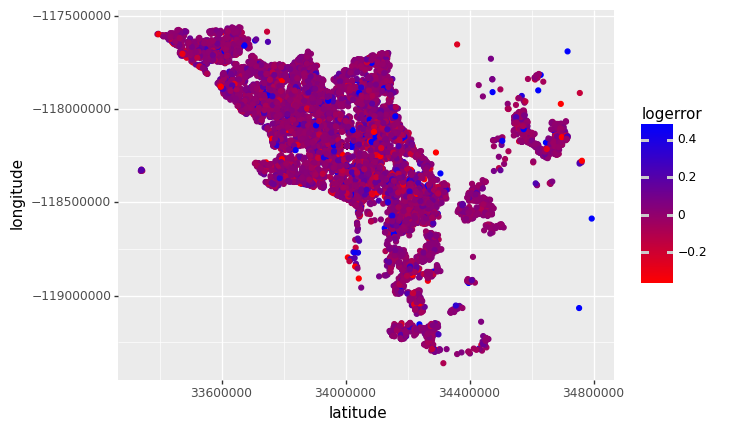

<ggplot: (8786903995737)>

In [40]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

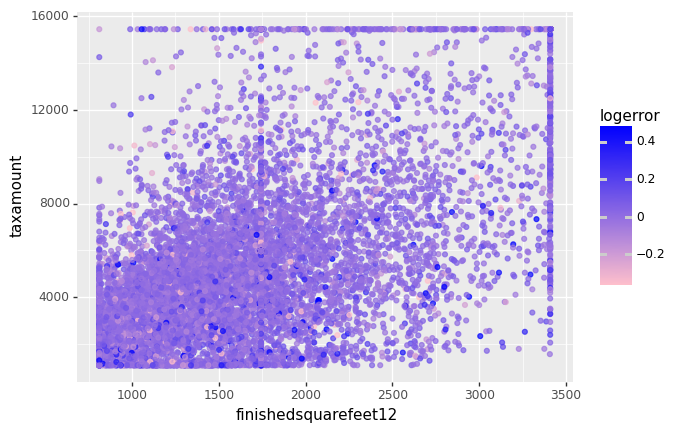

<ggplot: (8786893194293)>

In [41]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

## Ensemble : ExtraTreeRegressor

## Xgboost : DMatrix